# Import Libraries :

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage,cophenet,dendrogram
np.set_printoptions(suppress=True) # Avoid the number in exponent form
from sklearn.metrics.pairwise import euclidean_distances

# Read Data :

In [4]:
df = pd.read_csv("customer.csv")
df.head()

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score,Sex
0,CUSTID1,15000,18,44,0
1,CUSTID2,15000,18,79,0
2,CUSTID3,16000,23,8,1
3,CUSTID4,16000,25,79,1
4,CUSTID5,17000,32,41,1


In [5]:
from scipy.stats import chi2_contingency

# Example with two categorical variables 'variable1' and 'variable2'
contingency_table = pd.crosstab(df['Cust_Number'], df['Sex'])

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Print the p-value
print(f"Chi-square test p-value: {p}")

Chi-square test p-value: 0.4667457435013782


#### Make An Heat Map to get the Correlation between Variables

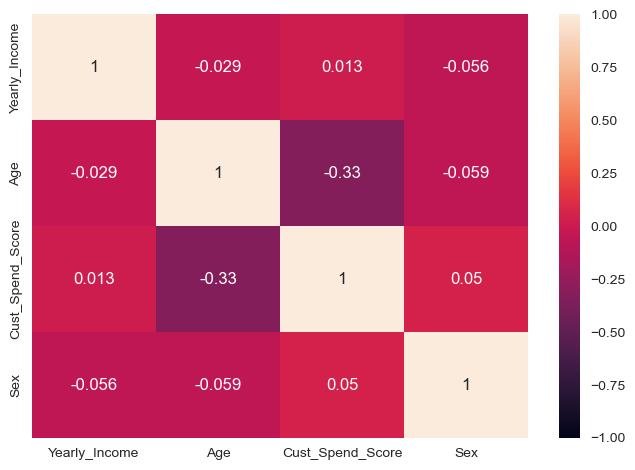

In [6]:
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1);

**Inferences for Heatmap :**
* Cust_Spend_score is having a Bad or Nagetive Relation With Age 
* Cust_Spend_score is Having a weak or Positive Relation with Sex

In [7]:
target_distribution = df['Sex'].value_counts(normalize=True)
target_distribution

1    0.56
0    0.44
Name: Sex, dtype: float64

#### RandomOverSampler

In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df.drop('Sex', axis=1), df['Sex'])
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Check the distribution of the target variable after resampling
resampled_target_distribution = df_resampled['Sex'].value_counts(normalize=True)
resampled_target_distribution
X_resampled.head()

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score
0,CUSTID1,15000,18,44
1,CUSTID2,15000,18,79
2,CUSTID3,16000,23,8
3,CUSTID4,16000,25,79
4,CUSTID5,17000,32,41


In [12]:
# a. Find out the number of rows and types of variables
num_rows = df.shape[0]
variable_info = df.dtypes

# b. Calculate five-point summary for numerical variables
numeric_summary = df.describe()

# c. Summarize observations for categorical variables
categorical_summary = df.describe(include='O')  # include='O' for object (categorical) data types

# Additional information on categorical variables
num_categories = df.nunique()  # Number of unique categories in each column
percent_in_each_category = df.apply(lambda x: x.value_counts(normalize=True).max())

# Print the results
print(f"a. Number of rows: {num_rows}")
print("   Variable Information:")
print(variable_info)

print("\nb. Five-point summary for numerical variables:")
print(numeric_summary)

print("\nc. Summarize observations for categorical variables:")
print("   Number of categories:")
print(num_categories)
print("\n   Percentage of observations in each category:")
print(percent_in_each_category)


a. Number of rows: 200
   Variable Information:
Cust_Number         object
Yearly_Income        int64
Age                  int64
Cust_Spend_Score     int64
Sex                  int64
dtype: object

b. Five-point summary for numerical variables:
       Yearly_Income         Age  Cust_Spend_Score         Sex
count     200.000000  200.000000        200.000000  200.000000
mean    60560.000000   39.095000         51.380000    0.560000
std     26264.721165   14.088592         26.034488    0.497633
min     15000.000000   17.000000          1.000000    0.000000
25%     41500.000000   28.000000         33.750000    0.000000
50%     61500.000000   36.000000         51.000000    1.000000
75%     78000.000000   49.250000         72.000000    1.000000
max    137000.000000   73.000000        103.000000    1.000000

c. Summarize observations for categorical variables:
   Number of categories:
Cust_Number         200
Yearly_Income        64
Age                  54
Cust_Spend_Score     87
Sex          

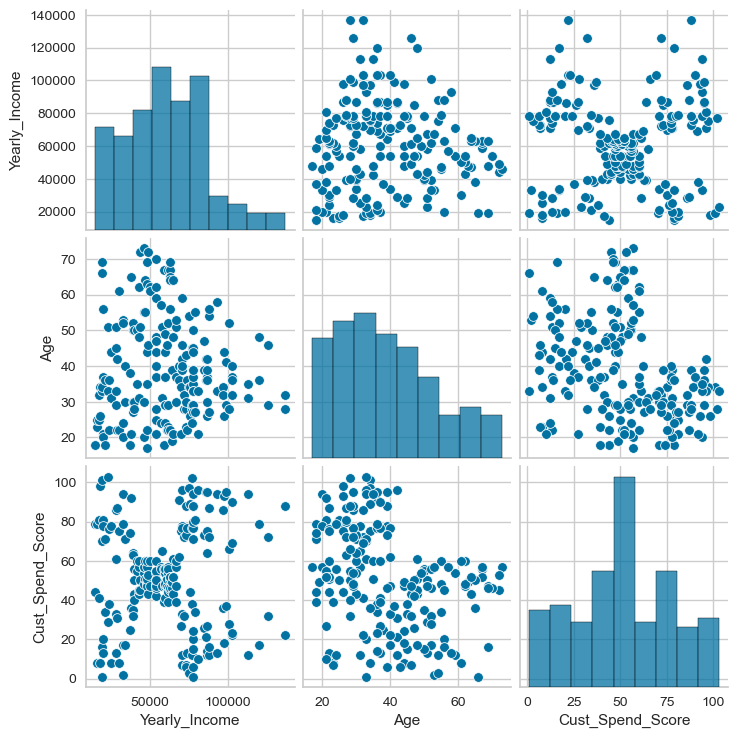

In [15]:
# visualize:
data = pd.read_csv("customer.csv")
cols = ["Yearly_Income","Age","Cust_Spend_Score"]
sns.pairplot(data[cols])
plt.show()

* In Cust_Spend_Score and YEarly_income we can clearly see some groups or the cluster in the data are forming ,we can 
*  use there two columns and use K-means clustering.

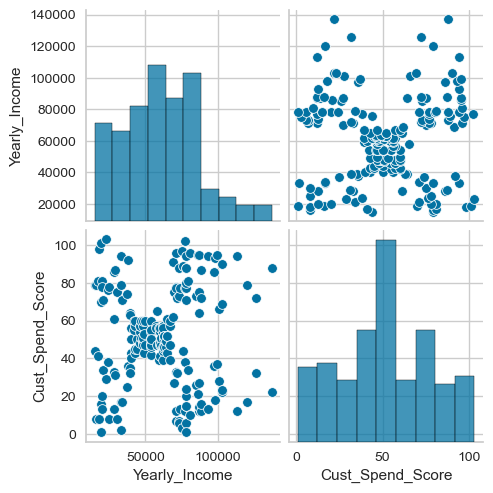

In [16]:
# visualize:
cols = ["Yearly_Income","Cust_Spend_Score"]
sns.pairplot(data[cols])
plt.show()

# Standard Scaling :

In [19]:
# we need to scale the data before clustering:
sc= StandardScaler()
data_c = sc.fit_transform(data_c)
data_c = pd.DataFrame(data_c,columns=["Yearly_Income","Cust_Spend_Score"])
data_c

,Yearly_Income,Cust_Spend_Score
0,-1.738999,-0.284181
1,-1.738999,1.063563
2,-1.700830,-1.670433
3,-1.700830,1.063563
4,-1.662660,-0.399702
...,...,...
195,2.268791,1.063563
196,2.497807,-0.746265
197,2.497807,0.794014
198,2.917671,-1.131335


# K-Means clustering :

## We need to identify the value of K:
#### 1-Elbow Plot
#### 2-Silhouette Score

In [20]:
n_culs = [2,3,4,5,6,7,8]
WCSS = []
for i in n_culs:
    model = KMeans(n_clusters=i)
    model.fit(data_c)
    WCSS.append(model.inertia_)

In [21]:
WCSS

[270.00076648257095,
 158.5731864827108,
 110.00511756050398,
 66.69647392440947,
 56.016232266055795,
 48.761052254810814,
 38.30690563322015]

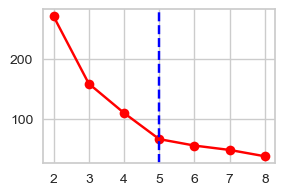

In [22]:
# Elbow Plot 
plt.figure(figsize=(3,2))
plt.plot(n_culs,WCSS,color="red",marker="o")
plt.axvline(x=5,color="blue",ls = "--")
plt.xticks(n_culs)
plt.show()

# This Blue Mark Is our Elbow.

In [16]:
# There is another way to draw this scree plot/Elbow plot by using yellowbrick Library.

In [23]:
K_elbow = KElbowVisualizer(KMeans(),k=8)

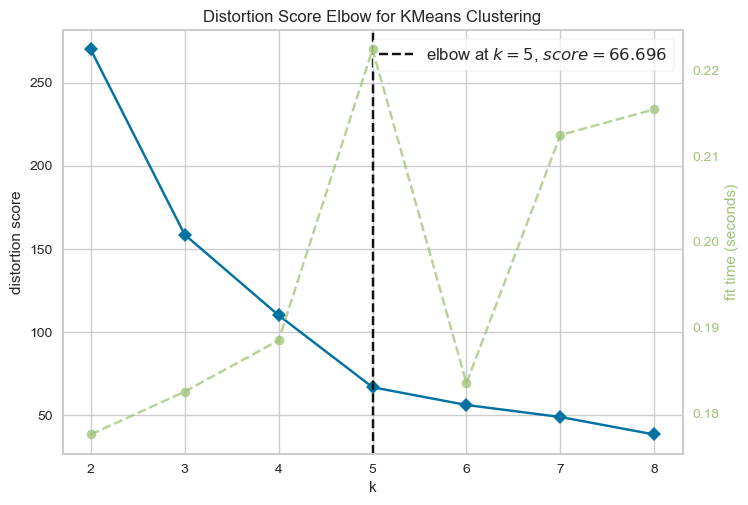

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
K_elbow.fit(data_c)
K_elbow.show()

In [25]:
# Another method is Silhoutte score to identify the Value of K:
sil_score = []
for i in n_culs:
    model = KMeans(n_clusters=i)
    model.fit(data_c)
    pred = model.predict(data_c) # prediction is done for 
    sil_score.append(silhouette_score(data_c,pred))

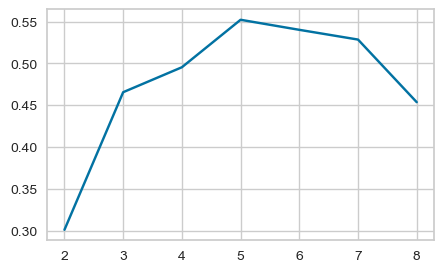

In [26]:
plt.figure(figsize=(5,3))
plt.plot(n_culs,sil_score)
plt.show()

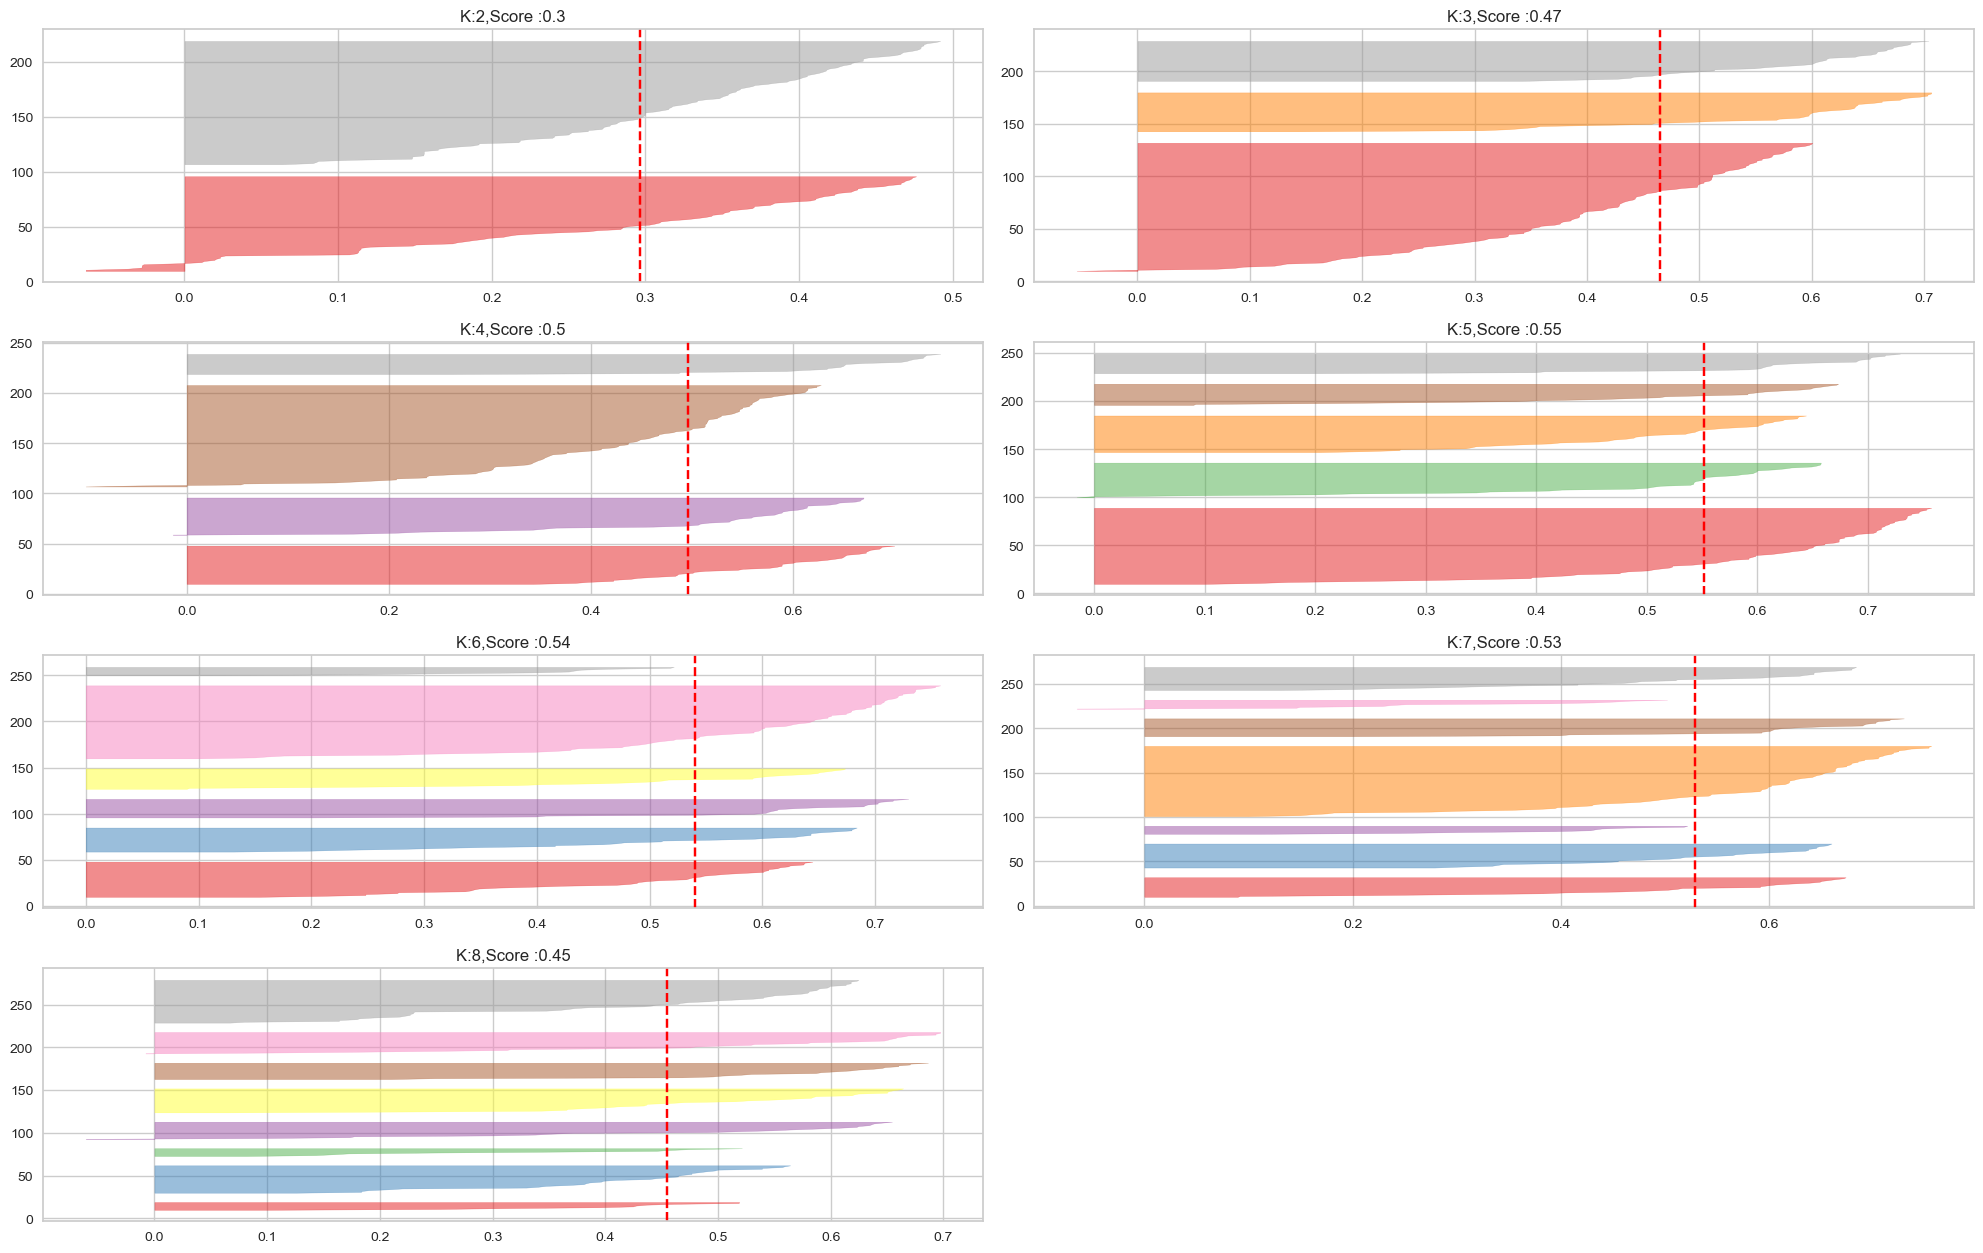

In [27]:
# Better way to Visualize the Silhouette Score is by YellowBrick :
t = 1
plt.figure(figsize=(20,25))
for i in n_culs:
    plt.subplot(8,2,t)
    model = KMeans(n_clusters=i)
    sil_viz = SilhouetteVisualizer(model)
    sil_viz.fit(data_c)
    plt.title(f"K:{i},Score :{np.round(sil_viz.silhouette_score_,2)}")
    t+=1
plt.tight_layout()
plt.show()

In [28]:
# As per K elbow plot and silhouette Vizualizer K = 5 is the best value of K for clusters.
# so we will create a model with K=5.
final_model = KMeans(n_clusters=5)
final_model.fit(data_c)

KMeans(n_clusters=5)

In [29]:
final_model.predict(data_c)  # so there are 5 label to predict

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0])

In [30]:
data["K_means_pred"] = final_model.predict(data_c)

In [31]:
data

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score,Sex,K_means_pred
0,CUSTID1,15000,18,44,0,4
1,CUSTID2,15000,18,79,0,2
2,CUSTID3,16000,23,8,1,4
3,CUSTID4,16000,25,79,1,2
4,CUSTID5,17000,32,41,1,4
...,...,...,...,...,...,...
195,CUSTID196,120000,36,79,1,0
196,CUSTID197,126000,46,32,1,1
197,CUSTID198,126000,29,72,0,0
198,CUSTID199,137000,32,22,0,1


In [32]:
data["K_means_pred"].value_counts()

3    80
0    39
1    37
4    23
2    21
Name: K_means_pred, dtype: int64

In [33]:
centroids = final_model.cluster_centers_ # 5 final centroid for 5 cluster
centroids

array([[ 0.99158305,  1.23437568],
       [ 1.02054738, -1.24685589],
       [-1.35366972,  1.16441429],
       [-0.22414997, -0.00693126],
       [-1.30751869, -1.12631231]])

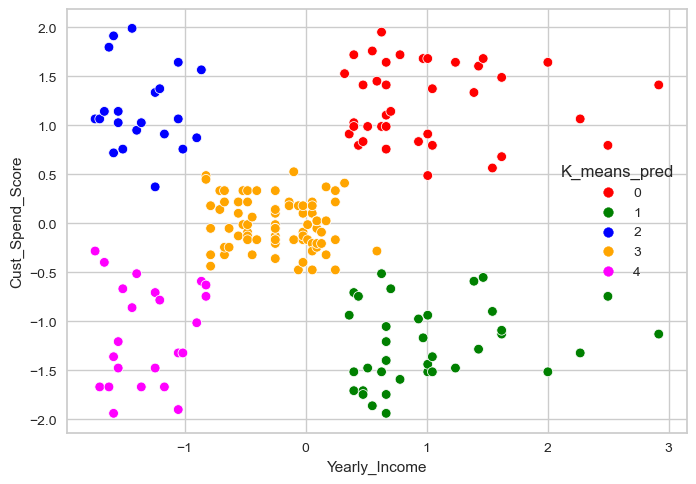

In [34]:
# visualize the clusters,so i use scatter plot
sns.scatterplot(x=data_c["Yearly_Income"],y=data_c["Cust_Spend_Score"],
                hue=data["K_means_pred"],palette=["red","green","blue","orange","magenta"])
plt.show()

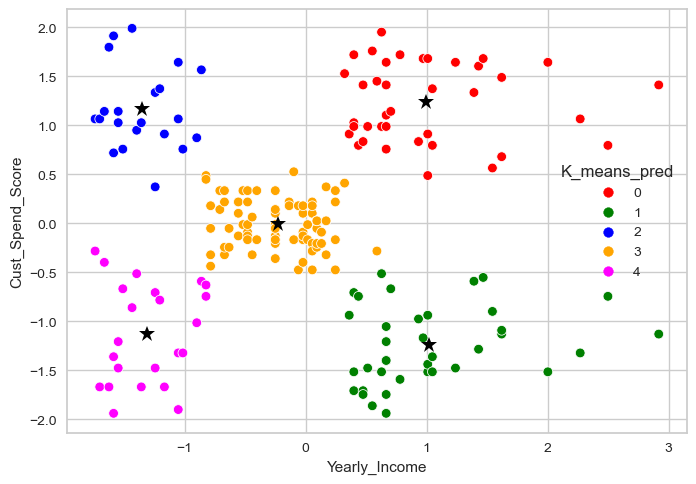

In [35]:
# lets Mark centroid as well:
sns.scatterplot(x=data_c["Yearly_Income"],y=data_c["Cust_Spend_Score"],
                hue=data["K_means_pred"],palette=["red","green","blue","orange","magenta"])
for i in range(5):
    plt.plot(centroids[i][0],centroids[i][1],color="Black",marker="*",ms=12)
plt.show()

In [36]:
data.groupby(by="K_means_pred").mean()[["Yearly_Income","Age","Cust_Spend_Score"]]

,Yearly_Income,Age,Cust_Spend_Score
K_means_pred,,,
0,86538.461538,32.589744,83.435897
1,87297.297297,40.567568,19.000000
2,25095.238095,25.000000,81.619048
3,54687.500000,43.387500,51.200000
4,26304.347826,45.695652,22.130435


# Agglomerative Clustering :

In [37]:
# lets create a linkage matrix
link_mat_complete=linkage(data_c,method="complete")

In [38]:
link_mat_complete.shape

(199, 4)

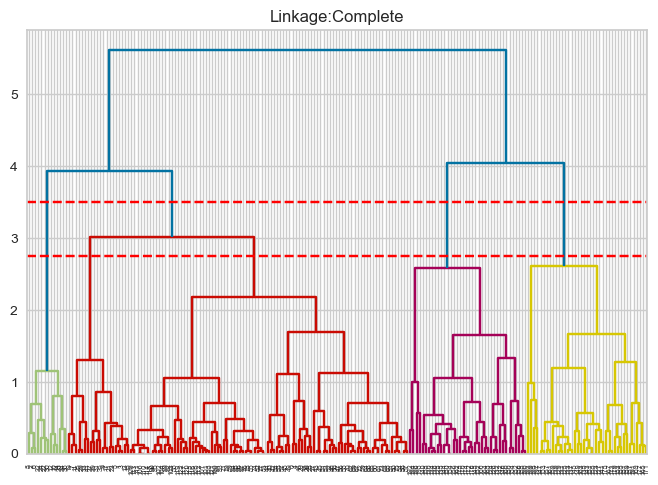

In [39]:
# lets create a dendogram:
plt.title("Linkage:Complete")
dendrogram(link_mat_complete)
plt.axhline(y=3.5,ls="--",color="red")
plt.axhline(y=2.75,ls="--",color="red")
plt.show()

* As per this horizontal line the correct value of k can be 4 or 5
* So we can use silhotte score to select the K

In [40]:
for i in [4,5]:
    model = AgglomerativeClustering(n_clusters=i)
    pred = model.fit_predict(data_c)
    print("K =",i,":",silhouette_score(data_c,pred))

K = 4 : 0.4880346129106644
K = 5 : 0.5446701394267819


In [41]:
# lets create a linkage matrix
link_mat_single=linkage(data_c,method="single")

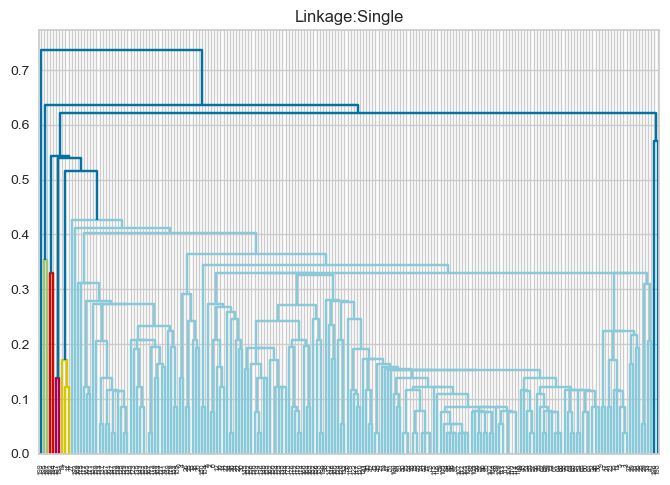

In [42]:
# lets create a dendogram:
plt.title("Linkage:Single")
dendrogram(link_mat_single)
plt.show()

In [48]:
# lets create a linkage matrix
link_mat_ward=linkage(data_c,method="ward")

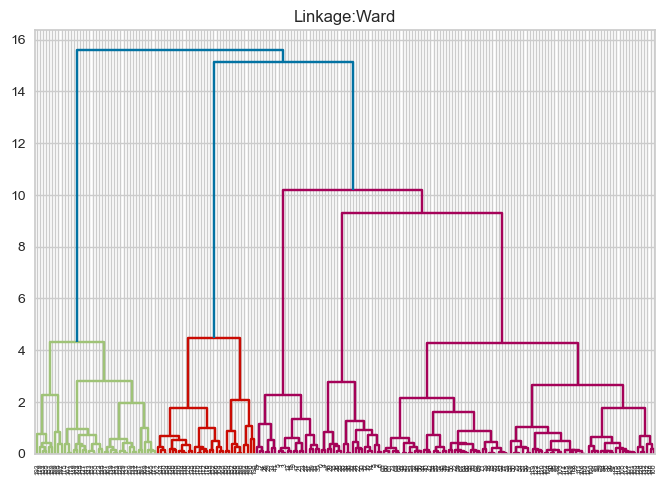

In [44]:
# lets create a dendogram:
plt.title("Linkage:Ward")
dendrogram(link_mat_ward)
plt.show()

In [50]:
# cophenetic Correlation coeff
# it is the correlation btw cophenetic distance(Dendogram Distance) and the actual distance
dist_matirx = euclidean_distances(data_c)
dist_matirx.shape

(200, 200)

In [51]:
actual_distance = dist_matirx[np.triu_indices(200,k=1)]
print(actual_distance.shape)
actual_distance[:5]

(19900,)


array([1.34774417, 1.38677653, 1.34828455, 0.13846554, 1.42680178])

In [52]:
# Cophenetic Distance comes from dendogram:
# lets calculate
ccc,cophenetic_dist = cophenet(link_mat_ward,actual_distance)
cophenetic_dist

array([10.18584645,  2.77784974, 10.18584645, ..., 15.58545986,
        0.83045284, 15.58545986])

In [53]:
np.corrcoef(actual_distance,cophenetic_dist)

array([[1.        , 0.71803964],
       [0.71803964, 1.        ]])

In [54]:
ccc

0.7180396352621479

In [55]:
agglo_final = AgglomerativeClustering(n_clusters=5)
agglo_final

AgglomerativeClustering(n_clusters=5)

In [56]:
data["agglo_pred"] = agglo_final.fit_predict(data_c)

In [57]:
data

,Cust_Number,Yearly_Income,Age,Cust_Spend_Score,Sex,K_means_pred,agglo_pred
0,CUSTID1,15000,18,44,0,4,4
1,CUSTID2,15000,18,79,0,2,3
2,CUSTID3,16000,23,8,1,4,4
3,CUSTID4,16000,25,79,1,2,3
4,CUSTID5,17000,32,41,1,4,4
...,...,...,...,...,...,...,...
195,CUSTID196,120000,36,79,1,0,1
196,CUSTID197,126000,46,32,1,1,0
197,CUSTID198,126000,29,72,0,0,1
198,CUSTID199,137000,32,22,0,1,0


In [58]:
data["agglo_pred"].value_counts()

2    88
1    39
0    32
3    21
4    20
Name: agglo_pred, dtype: int64

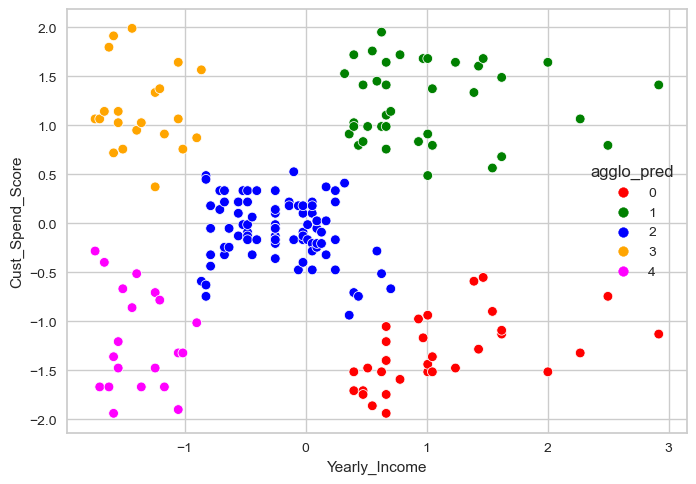

In [59]:
sns.scatterplot(x=data_c["Yearly_Income"],y=data_c["Cust_Spend_Score"],
                hue=data["agglo_pred"],palette=["red","green","blue","orange","magenta"])
plt.show()

### Thank You